## Step 3 - Climate Analysis and Exploration

You are now ready to use Python and SQLAlchemy to do basic climate analysis and data exploration on your new weather station tables. All of the following analysis should be completed using SQLAlchemy ORM queries, Pandas, and Matplotlib.

* Create a Jupyter Notebook file called `climate_analysis.ipynb` and use it to complete your climate analysis and data exploration.

* Choose a start date and end date for your trip. Make sure that your vacation range is approximately 3-15 days total.

* Use SQLAlchemy `create_engine` to connect to your sqlite database.

* Use SQLAlchemy `automap_base()` to reflect your tables into classes and save a reference to those classes called `Station` and `Measurement`.


In [1]:
import pandas as pd
import numpy as np
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
from sqlalchemy.ext.automap import automap_base
from datetime import datetime, timedelta
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
engine = create_engine('sqlite:///raw_data/hawaii.sqlite')
Base = automap_base()
Base.prepare(engine, reflect=True)
session = Session(bind=engine)
inspector = inspect(engine)

In [3]:
# Visual Schema - verify the database has the info we are expecting
for table_name in inspector.get_table_names():
    for column in inspector.get_columns(table_name):
        print(table_name, column.get('name'), column.get('type'))
    print()

hawaii_measurements obs_id INTEGER
hawaii_measurements station VARCHAR
hawaii_measurements datetime DATE
hawaii_measurements date VARCHAR
hawaii_measurements prcp FLOAT
hawaii_measurements tobs FLOAT

hawaii_stations station_id VARCHAR
hawaii_stations name VARCHAR
hawaii_stations latitude FLOAT
hawaii_stations longitude FLOAT
hawaii_stations elevation FLOAT



In [4]:
Measurement = Base.classes.hawaii_measurements

In [5]:
Station = Base.classes.hawaii_stations

### Precipitation Analysis Directions

* Design a query to retrieve the last 12 months of precipitation data.

* Select only the `date` and `prcp` values.

* Load the query results into a Pandas DataFrame and set the index to the date column.

* Plot the results using the DataFrame `plot` method.

<center><img src='Instructions/Images/precip.png' width="400px"/></center>

* Use Pandas to print the summary statistics for the precipitation data.



In [6]:
#find the date 12 months ago to be able to filter query
last_precip_date = max(session.query(Measurement.datetime))[0]
print(last_precip_date)
print(type(last_precip_date))
year_ago_precip_date = last_precip_date - timedelta(days=365)
print(year_ago_precip_date)
print(type(year_ago_precip_date))

2017-08-23
<class 'datetime.date'>
2016-08-23
<class 'datetime.date'>


In [7]:
#retrieve the last 12 months of data
last_12_months_precip = session.query(Measurement.datetime, Measurement.prcp.label('precipitation'))\
                        .filter(Measurement.datetime > year_ago_precip_date)
#put data into a dataframe
df_precip_last_12_months = pd.read_sql(last_12_months_precip.statement, session.bind, index_col='datetime')
#sort data by date
df_precip_last_12_months.sort_index(inplace=True)

print(df_precip_last_12_months.shape)
df_precip_last_12_months.head()

(2015, 1)


,precipitation
datetime,
2016-08-24,0.08
2016-08-24,1.22
2016-08-24,2.28
2016-08-24,1.45
2016-08-24,2.15


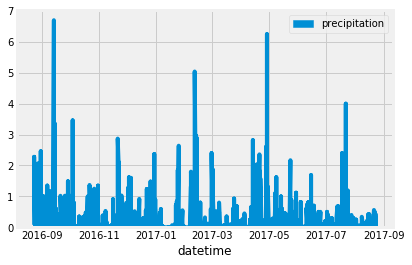

In [9]:
df_precip_last_12_months.plot.area();

In [10]:
df_precip_last_12_months.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis Directions

* Design a query to calculate the total number of stations.

* Design a query to find the most active stations.

  * List the stations and observation counts in descending order

  * Which station has the highest number of observations?

* Design a query to retrieve the last 12 months of temperature observation data (tobs).

  * Filter by the station with the highest number of observations.

  * Plot the results as a histogram with `bins=12`.

  <center><img src='Instructions/Images/temp_hist.png' width="400px" /></center>



In [11]:
total_stations = session.query(Measurement.station)\
                        .distinct(Measurement.station).count()
print(f"Total # of Stations in Measurement Data = {total_stations}")

Total # of Stations in Measurement Data = 9


In [12]:
#determine the number of observations each station recorded to see which 
#station is the most active
station_recorded_observations = session.query(Measurement.station,
                                              func.count(Measurement.station))\
                                .group_by(Measurement.station)\
                                .order_by(func.count(Measurement.station).desc())\
                                .all()
station_most_observations = station_recorded_observations[0][0]
print(f"Station {station_most_observations} had the highest number of observations.")
print("")
print("(Station, # Observations)")
print("---------------------")
station_recorded_observations

Station USC00519281 had the highest number of observations.

(Station, # Observations)
---------------------


[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [16]:
#last 12 months of temperature data for stations with most observations
tobs_last_12_station_most_obs = session.query(Measurement.tobs)\
                                .filter(Measurement.datetime > year_ago_precip_date)\
                                .filter(Measurement.station == station_most_observations)\
                                .all()
#query returns as list of tuples, so unpack to pure list
tobs_plot=[tuple[0] for tuple in tobs_last_12_station_most_obs]

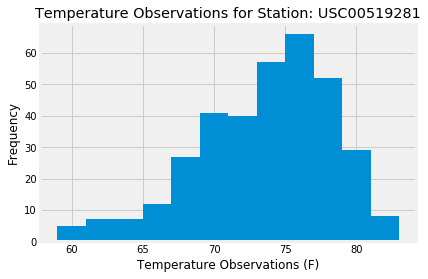

In [49]:
plt.title(f'Temperature Observations for Station: {station_most_observations}')
plt.ylabel('Frequency')
plt.xlabel('Temperature Observations (F)')
plt.hist(tobs_plot, bins=12, label='tobs');

### Temperature Analysis Directions

* Write a function called `calc_temps` that will accept a start date and end date in the format `%Y-%m-%d` and return the minimum, average, and maximum temperatures for that range of dates.


* Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")

* Plot the min, avg, and max temperature from your previous query as a bar chart.

  * Use the average temperature as the bar height.

  * Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

<center><img src='Instructions/Images/temp_avg.png' width="200px"/></center>



In [18]:
#will calculate the min, max, and average temperature over the previous year's timeframe
#function accepts dates in form of %Y-%m-%d
def calc_temps(start_date, end_date):
    #convert times to 2016 year and datetime objects
    #use 2016 data because 2017 data is incomplete - only goes through 8/23
    #and temp data isn't updating so won't be able to have relative previous
    #year data for vacation dates in future
    start_date_2016 = '2016' + start_date[4:]
    end_date_2016 = '2016' + end_date[4:]
    start_date_2016_dt = datetime.strptime(start_date_2016, '%Y-%m-%d')
    end_date_2016_dt = datetime.strptime(end_date_2016, '%Y-%m-%d')
                   
    temp_data_2016_min_max_avg = session.query(func.min(Measurement.tobs),
                                         func.max(Measurement.tobs),
                                         func.avg(Measurement.tobs))\
                                .filter(Measurement.datetime >= start_date_2016_dt)\
                                .filter(Measurement.datetime <= end_date_2016_dt)\
                                .all()
    temp_min = temp_data_2016_min_max_avg[0][0] 
    temp_max = temp_data_2016_min_max_avg[0][1]
    temp_avg = temp_data_2016_min_max_avg[0][2]
    print(f"Temperature Summary from 2016 date range: \nMin={temp_min}, Max={temp_max}, Avg={temp_avg}")
    return temp_min, temp_max, temp_avg

In [50]:
#calculate temp min, max, avg for given date range
temp_min, temp_max, temp_avg = calc_temps("2019-02-05","2019-02-19")

Temperature Summary from 2016 date range: 
Min=56.0, Max=79.0, Avg=69.78205128205128


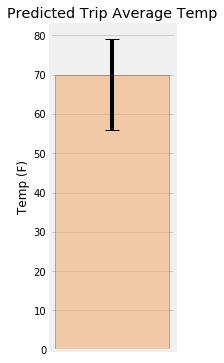

In [52]:
# #bar plot with error marks
plt.figure(figsize=(2,6))
# Create orange bars
plt.bar(x=0.5, height=temp_avg, width=0.25, align='center', 
        color = 'sandybrown', edgecolor = 'black',
        alpha = 0.5,
        yerr=[[temp_avg-temp_min], [temp_max-temp_avg]], #[(temp_avg-temp_min), (temp_max-temp_avg)], #(temp_avg-temp_min),(temp_max-temp_avg)]  (temp_max-temp_min)/2
        capsize=7)

plt.xticks([])
plt.ylabel('Temp (F)')
plt.title('Predicted Trip Average Temp')
  
# Show graphic
plt.show()


### Optional Recommended Analysis Directions

* The following are optional challenge queries. These are highly recommended to attempt, but not required for the homework.

  * Calculate the rainfall per weather station using the previous year's matching dates.

* Calculate the daily normals. Normals are the averages for min, avg, and max temperatures.

  * Create a function called `daily_normals` that will calculate the daily normals for a specific date. This date string will be in the format `%m-%d`. Be sure to use all historic tobs that match that date string.

  * Create a list of dates for your trip in the format `%m-%d`. Use the `daily_normals` function to calculate the normals for each date string and append the results to a list.

  * Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.

  * Use Pandas to plot an area plot (`stacked=False`) for the daily normals.

  <center><img src="Instructions/Images/daily_normals.png" width="400px"/></center>

In [21]:
#rainfall per weather station using previous years dates for your vacation dates
#function accepts dates in form of %Y-%m-%d
def rainfall_per_station(start_date, end_date):
    #convert times to 2016 year and datetime objects
    #use 2016 data because 2017 data is incomplete - only goes through 8/23
    #and temp data isn't updating so won't be able to have relative previous
    #year data for vacation dates in future
    start_date_2016 = '2016' + start_date[4:]
    end_date_2016 = '2016' + end_date[4:]
    start_date_2016_dt = datetime.strptime(start_date_2016, '%Y-%m-%d')
    end_date_2016_dt = datetime.strptime(end_date_2016, '%Y-%m-%d')
                   
    rainfall_data_2016_per_station = session.query(Measurement.station, func.sum(Measurement.prcp).label('sum_precip'))\
                                .filter(Measurement.datetime >= start_date_2016_dt)\
                                .filter(Measurement.datetime <= end_date_2016_dt)\
                                .group_by(Measurement.station)\
                                .order_by(func.sum(Measurement.prcp).desc())
    
    df_rainfall = pd.read_sql(rainfall_data_2016_per_station.statement, session.bind, index_col='station')
    return df_rainfall

In [22]:
rainfall_per_station("2019-02-05","2019-02-19")

,sum_precip
station,
USC00516128,1.27
USC00514830,1.04
USC00513117,0.53
USC00519523,0.46
USC00519281,0.44
USC00519397,0.33
USC00517948,0.00


In [33]:
#Create a function called daily_normals that will calculate the daily normals for a specific date. This date string will be
#in the format %m-%d. Be sure to use all historic tobs that match that date string.
def daily_normals(month_day_str):
    min_max_avg_all_years = session.query(func.min(Measurement.tobs),
                                         func.max(Measurement.tobs),
                                         func.avg(Measurement.tobs))\
                                .filter(Measurement.datetime.like(f"%{month_day_str}%"))\
                                .all()
    temp_min = min_max_avg_all_years[0][0] 
    temp_max = min_max_avg_all_years[0][1]
    temp_avg = min_max_avg_all_years[0][2]
    #print(f"Historical Temperature Summary on Month-Day: {month_day_str} \nMin={temp_min}, Max={temp_max}, Avg={temp_avg}")
    return temp_min, temp_max, temp_avg

In [61]:
# Create a list of dates for your trip in the format %m-%d. Use the daily_normals function to calculate 
#the normals for each date string and append the results to a list.
vacation_m_d = ["02-05", "02-06", "02-07", "02-08", "02-09", "02-10", "02-11", "02-12", "02-13", "02-14", "02-15", "02-16", "02-17", "02-18", "02-19"]

normals=[]
for day in vacation_m_d:
    normals.append(daily_normals(day))

# Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.
normals_df = pd.DataFrame(data=normals, columns=['temp_min', 'temp_max', 'temp_avg'], index=vacation_m_d)
print(normals_df.shape)
normals_df.head()

(15, 3)


,temp_min,temp_max,temp_avg
02-05,59.0,77.0,69.294118
02-06,58.0,77.0,70.288462
02-07,60.0,77.0,68.849057
02-08,56.0,74.0,66.727273
02-09,57.0,75.0,67.442308


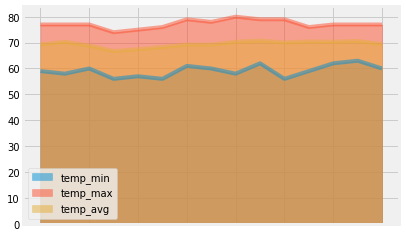

In [64]:
normals_df.plot.area(stacked=False);

In [65]:
#at very end close the session
session.close_all()